# <Span style = 'color: #008B8B'> NLP Data Modeling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#NLP library 
import re
import unicodedata
import nltk
from wordcloud import WordCloud


%matplotlib inline
import matplotlib.pyplot as plt


from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.tokenize.toktok import ToktokTokenizer
from pprint import pprint
#My libraries 
import acquire as a 
from env import user, password, hostname


#Beautiful Soup and Webscrape
from requests import get
from bs4 import BeautifulSoup


#Modeling 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


import warnings


# Disable all warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

## <Span style = 'color: #008B8B'>ACQUIRE 
### <span style = 'color: purple'>1.Spam Data

#### a. Load the spam data set.

In [2]:
def get_connection(db_name, hostname=hostname, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{hostname}/{db_name}'


url = get_connection("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## <Span style = 'color: #008B8B'> PREPARE

In [3]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [4]:
#Value counts of labels
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [5]:
#Example of text
df.iloc[1].text

'Ok lar... Joking wif u oni...'

In [6]:
#Ham vs Spam

labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [7]:
# Ham vs Spam function
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")


,n,percent
ham,4825,0.865937
spam,747,0.134063


Break the data up into 3 seperate pieces:

- The words that appear in legitimate text messages.
- The words that appear in spam text messages.
- All of the words.


In [8]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))


## <Span style = 'color: #008B8B'> EXPLORE SPAM DATA

#### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
Is there any overlap in the bigrams for the spam data and the ham data?

In [9]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [10]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()



(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

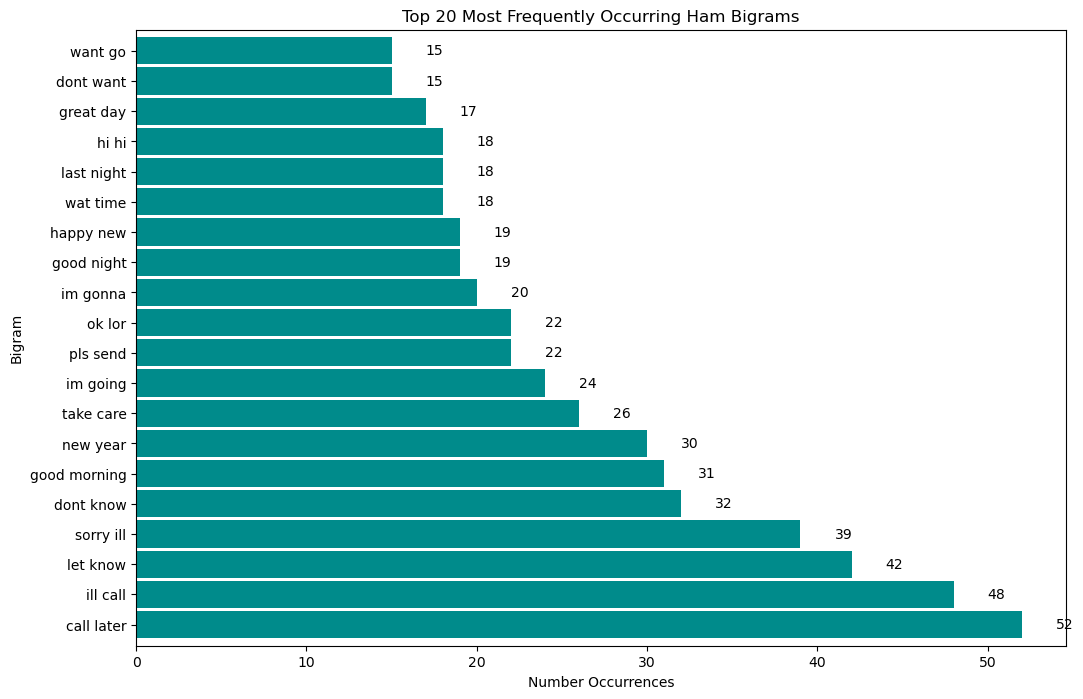

In [11]:
# Sort the bigrams in descending order by frequency
top_20_ham_bigrams = top_20_ham_bigrams.sort_values(ascending=False)

# Create the horizontal bar plot
plt.figure(figsize=(12, 8))
bars = top_20_ham_bigrams.plot(kind='barh', color = '#008B8B', width=0.9)

# Add count annotations at the end of the bars
for bar in bars.patches:
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height() / 2, 
             f'{int(bar.get_width())}', 
             va='center', ha='left', fontsize=10, color='black')

plt.title('Top 20 Most Frequently Occurring Ham Bigrams')
plt.xlabel('Number Occurrences')
plt.ylabel('Bigram')

# Make the labels pretty
ticks, labels = plt.yticks()
new_labels = [f'{bigram[0]} {bigram[1]}' for bigram in top_20_ham_bigrams.index]
plt.yticks(ticks, new_labels)

plt.show()


#### BIGRAM WORD CLOUD

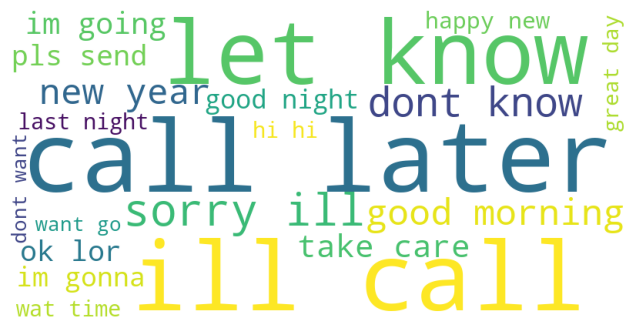

In [12]:

data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


### The barplot and word cloud are similar. Showing 'call later','ill call' and 'let know' as the most frequent

## <Span style = 'color: #008B8B'> MODEL 

In [13]:


# From the Series we can extract the value_counts, which is our raw count
# for term frequency. Once we have the raw counts, we can calculate the
# other measures.
(pd.DataFrame({'raw_count': spam_freq.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

,raw_count,frequency,augmented_frequency
1,1412,0.501777,1.000000
2,565,0.200782,0.400142
3,203,0.072139,0.143768
4,129,0.045842,0.091360
5,90,0.031983,0.063739
...,...,...,...
49,1,0.000355,0.000708
46,1,0.000355,0.000708
42,1,0.000355,0.000708
38,1,0.000355,0.000708


In [16]:
pprint(spam_freq)

print('\nCleaning and lemmatizing...\n')

texts = {topic: lemmatize(clean(spam_freq[sorted_bigrams])) for bigram in texts}
pprint(texts)

call      359
free      216
txt       150
ur        144
text      137
         ... 
9153        1
26th        1
okmail      1
moan        1
now1        1
Length: 2814, dtype: int64

Cleaning and lemmatizing...



NameError: name 'texts' is not defined

In [14]:

# Load and preprocess data (replace with your own preprocessing steps)
data = df


# Create feature vectors
tf_vectorizer = CountVectorizer(max_features=1000)  # You can adjust max_features
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features

X_tf = tf_vectorizer.fit_transform(data['text']).toarray()
X_tfidf = tfidf_vectorizer.fit_transform(data['text']).toarray()
y = data['label']

# Split the data
X_train_tf, X_test_tf, y_train, y_test = train_test_split(X_tf, y, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Build and train models
model_tf = LogisticRegression()
model_tfidf = LogisticRegression()

model_tf.fit(X_train_tf, y_train)
model_tfidf.fit(X_train_tfidf, y_train)

# Evaluate performance
y_pred_tf = model_tf.predict(X_test_tf)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

accuracy_tf = accuracy_score(y_test, y_pred_tf)
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

print("TF Model Accuracy:", accuracy_tf)
print("TF-IDF Model Accuracy:", accuracy_tfidf)

print("TF Model Classification Report:")
print(classification_report(y_test, y_pred_tf))

print("TF-IDF Model Classification Report:")
print(classification_report(y_test, y_pred_tfidf))


TF Model Accuracy: 0.9775784753363229
TF-IDF Model Accuracy: 0.9721973094170404
TF Model Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       0.98      0.85      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115

TF-IDF Model Classification Report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       965
        spam       0.98      0.81      0.89       150

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



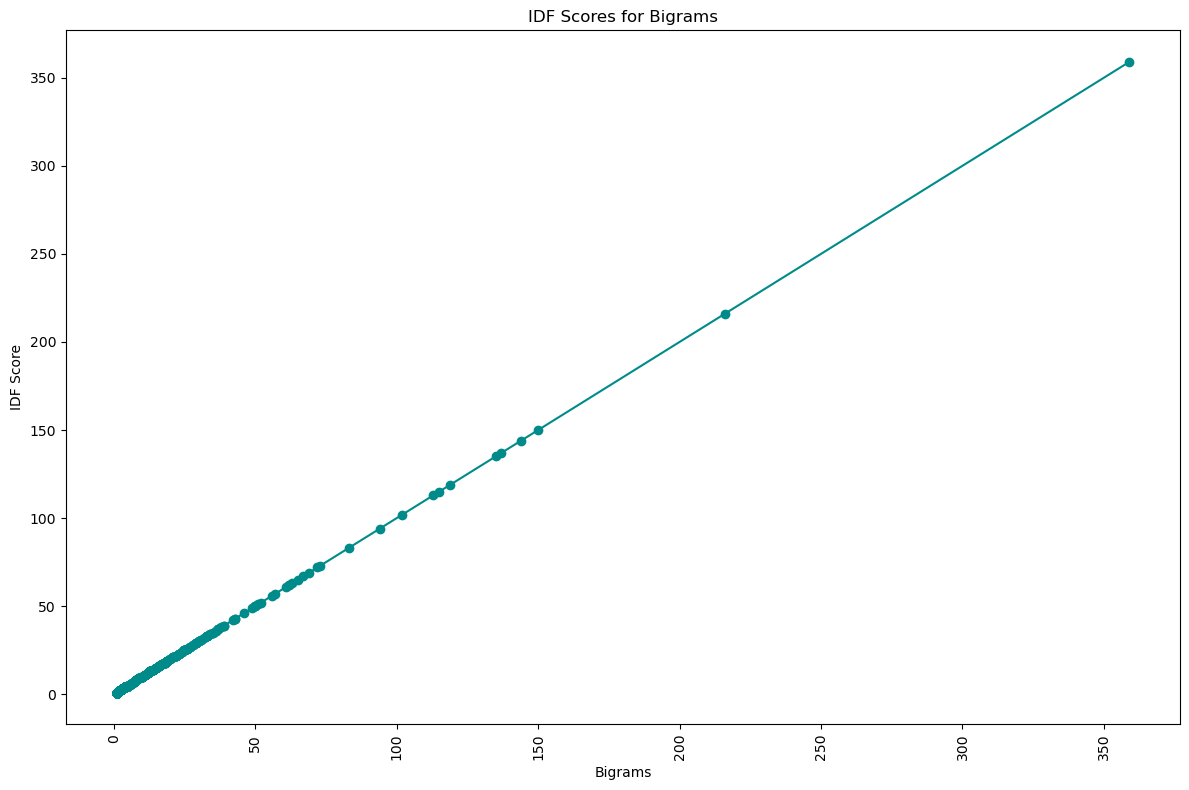

In [15]:
#Line plot for Bigrams by IDF

# Sort the bigrams by IDF value in descending order
sorted_bigrams = sorted(spam_freq.items(), key=lambda x: x[1], reverse=True)

# Extract bigrams and corresponding IDF values for plotting
bigrams = [item[1] for item in sorted_bigrams]
idf_scores = [item[1] for item in sorted_bigrams]

# Create the line plot
plt.figure(figsize=(12, 8))
plt.plot(bigrams, idf_scores, marker='o', color='#008B8B', linestyle='-')

plt.title('IDF Scores for Bigrams')
plt.xlabel('Bigrams')
plt.ylabel('IDF Score')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
